<a href="https://colab.research.google.com/github/florencianionquepan/analisis_hidratos_offshore/blob/main/An%C3%A1lisis_de_Hidratos_en_L%C3%ADnea_de_Producci%C3%B3n_Offshore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introducción

La formación de hidratos en líneas de producción offshore es un problema crítico en la industria del petróleo y gas. Estas estructuras cristalinas pueden generar bloqueos en las tuberías, afectando la continuidad operativa, aumentando costos de mantenimiento y representando riesgos para la seguridad. Los hidratos se forman bajo condiciones específicas de presión y temperatura, por lo que su monitoreo y control son esenciales para evitar fallas en la producción.

En este proyecto, se analizara el fenómeno de la formación de hidratos en líneas de producción de pozos petroleros utilizando el conjunto de datos 3W. La formación de hidratos, compuestos cristalinos de agua y gas natural similares al hielo, representa uno de los mayores desafíos en la industria petrolera, con el potencial de interrumpir el flujo y generar pérdidas de producción significativas. El conjunto de datos 3W, un recurso público y realista, ofrece instancias de eventos no deseados en pozos petroleros, incluyendo datos relacionados con la formación de hidratos. Este conjunto de datos contiene información de pozos marinos de flujo natural e incluye las siguientes variables de proceso monitoreadas comúnmente:

* Presión en el PDG
* Presión en el TPT
* Temperatura en el TPT
* Presión aguas arriba del PCK
* Temperatura aguas abajo del PCK


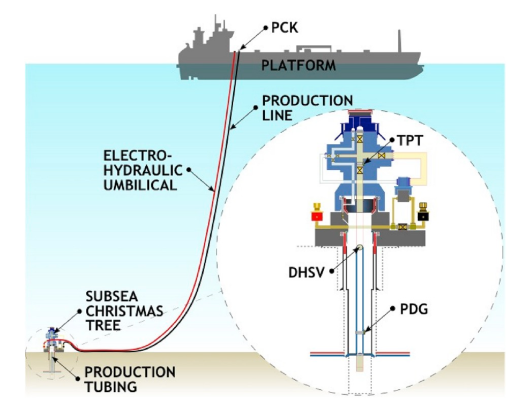


Este análisis se centrará en el tipo de evento no deseado número 8, "Hidrato en la línea de producción"

El conjunto de datos 3W se compone de instancias reales, simuladas y dibujadas a mano, lo que proporciona una base de datos rica y diversa para el desarrollo y la evaluación comparativa de técnicas de aprendizaje automático. En este Colab, exploraremos diversas técnicas de preprocesamiento, selección de características y algoritmos de clasificación para lograr un rendimiento óptimo en la detección de hidratos.
Finalmente, este análisis contribuirá al campo de la gestión de eventos anormales (AEM) en pozos petroleros, con el objetivo de mejorar la seguridad operativa, reducir los costos de mantenimiento y prevenir accidentes ambientales


# Carga del Data set

Se cargan los datos en archivos CSV para trabajar en principio con este formato. Actualmente, el repositorio de Petrobras muestra estos datos en archivos Parquet.

Los archivos Parquet son un formato de almacenamiento optimizado para Big Data, diseñado para ser eficiente en almacenamiento y lectura. Su estructura columnar permite una mejor compresión y acceso más rápido a los datos en comparación con formatos como CSV o JSON, además de ser compatible con herramientas como Apache Spark, Hadoop y Pandas.

Sin embargo, en este trabajo del curso, se utilizan archivos CSV inicialmente para simplificar el procesamiento y manipulación de datos, ya que es un formato más accesible y fácil de manejar sin requerir configuraciones avanzadas o herramientas adicionales.


Desde aqui se dsecomprimio el zip subido:

In [ ]:
!cp /content/drive/MyDrive/DataScience/Entrega1/8.zip /content/dataset.zip

In [ ]:
!unzip -o /content/dataset.zip -d /content/dataset/


Archive:  /content/dataset.zip
   creating: /content/dataset/8/
  inflating: /content/dataset/8/SIMULATED_00001.csv  
  inflating: /content/dataset/8/SIMULATED_00002.csv  
  inflating: /content/dataset/8/SIMULATED_00003.csv  
  inflating: /content/dataset/8/SIMULATED_00004.csv  
  inflating: /content/dataset/8/SIMULATED_00005.csv  
  inflating: /content/dataset/8/SIMULATED_00006.csv  
  inflating: /content/dataset/8/SIMULATED_00007.csv  
  inflating: /content/dataset/8/SIMULATED_00008.csv  
  inflating: /content/dataset/8/SIMULATED_00009.csv  
  inflating: /content/dataset/8/SIMULATED_00010.csv  
  inflating: /content/dataset/8/SIMULATED_00011.csv  
  inflating: /content/dataset/8/SIMULATED_00012.csv  
  inflating: /content/dataset/8/SIMULATED_00013.csv  
  inflating: /content/dataset/8/SIMULATED_00014.csv  
  inflating: /content/dataset/8/SIMULATED_00015.csv  
  inflating: /content/dataset/8/SIMULATED_00016.csv  
  inflating: /content/dataset/8/SIMULATED_00017.csv  
  inflating: /cont

A fin de familiarse con los datos a analizar, se cargaran todos los csvs en dataframes. Segun la documentacion leida, todos los csvs contienen las mismas columnas, y segun las reglas todos los csvs deben ser considerados para un analisis correcto por lo que en este punto se asegura que todos contengan las mismas columnas y se describira que significa cada una.

In [ ]:
import pandas as pd
import os
import re

data_path='/content/dataset/8'

dfs = {}  # Diccionario para almacenar los DataFrames

# Obtener todos los archivos CSV en la carpeta
files = [file for file in os.listdir(data_path) if file.endswith(".csv")]

# Separar los archivos en listas distintas
simulated_files = sorted(
    [file for file in files if file.startswith("SIMULATED")],
    key=lambda x: int(re.search(r'\d+', x).group())  # Extraer número y ordenar
)

well_files = sorted(
    [file for file in files if file.startswith("WELL") or file.startswith("WEL")],
    key=lambda x: int(re.search(r'\d+', x).group())  # Extraer número y ordenar
)

# Unir las listas con SIMULATED primero y WELL después
sorted_files = simulated_files + well_files

# Cargar los archivos en el diccionario ordenado
for file in sorted_files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    dfs[file] = df  # Guardar el DataFrame con su nombre de archivo

print(f"Se cargaron {len(dfs)} archivos CSV.")

# Verificar el primer y último archivo en el diccionario
first_file = next(iter(dfs))
last_file = list(dfs.keys())[-1]

print(f"\n📂 Primer archivo en el diccionario: {first_file}")
print(f"📂 Último archivo en el diccionario: {last_file}")

for file, df in dfs.items():
    print(f"\n📂 Archivo: {file}")
    print(df.columns.tolist())  # Lista de nombres de columnas

Se cargaron 84 archivos CSV.

📂 Primer archivo en el diccionario: SIMULATED_00001.csv
📂 Último archivo en el diccionario: WELL-00021_20170509013517.csv

📂 Archivo: SIMULATED_00001.csv
['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL', 'class']

📂 Archivo: SIMULATED_00002.csv
['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL', 'class']

📂 Archivo: SIMULATED_00003.csv
['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL', 'class']

📂 Archivo: SIMULATED_00004.csv
['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL', 'class']

📂 Archivo: SIMULATED_00005.csv
['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL', 'class']

📂 Archivo: SIMULATED_00006.csv
['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL',

Como se puede ver, todos los csvs contienen los mismos nombres de columnas:


1. timestamp: Marca de tiempo que indica el momento exacto en que se registró cada medición. Está en formato "AAAA-MM-DD HH:MM:SS.ssssss" (año-mes-día hora:minuto:segundo.milisegundos), lo que permite un análisis temporal preciso de los datos
2. P-PDG: Presión del fluido en el PDG [Pa]
3. P-TPT: Presión del fluido en el TPT [Pa]
4. T-TPT:  Temperatura del fluido en el TPT [C]
5. P-MON-CKP: Presión del fluido antes de la válvula CKP [Pa]
6. T-JUS-CKP: Temperatura del fluido después de la válvula CKP [C]
7. P-JUS-CKGL: Presión del fluido después de la válvula de control de gas lift [Pa]
8. T-JUS-CKGL:  Temperatura del fluido después de la válvula de control de gas lift [C]
9. QGL: Caudal de gas lift [sm3/s]
10. class: Etiqueta que indica el estado del sistema en cada registro. Puede tomar diferentes valores, 0: Estado normal, sin anomalias. 3 y 103: eventos anomales detectados. De todas maneras, no se encontro aun ninguna referencia a estos codigos especificos.



# Exploración y visualización (EDA): conociendo el data set

Dado que se cuenta con las mismas columnas en todos los archivos, se exploraran algunas filas y dimensiones de un archivo en especifico:

In [ ]:
# Obtener la primera clave del diccionario (que es el nombre del archivo)
first_file = next(iter(dfs))

# Acceder al DataFrame correspondiente a ese archivo
df_1 = dfs[first_file]

print(f"\n📂 Primer archivo en el diccionario: {first_file}")

# Primeras filas
print("\nPrimeras filas:")
print(df_1.head())

# Últimas filas
print("\nÚltimas filas:")
print(df_1.tail())

# Dimensiones del DataFrame
print("\nDimensiones (filas, columnas):")
print(df_1.shape)

# Información general sobre el DataFrame
print("\nInformación general sobre el DataFrame:")
print(df_1.info())

# Columnas del DataFrame
print("\nColumnas del DataFrame:")
print(df_1.columns.tolist())


📂 Primer archivo en el diccionario: SIMULATED_00001.csv

Primeras filas:
                    timestamp       P-PDG       P-TPT     T-TPT  P-MON-CKP  \
0  2018-05-17 22:56:06.000000  27897490.0  19824230.0  125.6859  4059666.0   
1  2018-05-17 22:56:07.000000  27897450.0  19824230.0  125.6859  4059666.0   
2  2018-05-17 22:56:08.000000  27897360.0  19824230.0  125.6859  4059666.0   
3  2018-05-17 22:56:09.000000  27897430.0  19824230.0  125.6859  4059666.0   
4  2018-05-17 22:56:10.000000  27897500.0  19824230.0  125.6859  4059666.0   

   T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
0   97.55283         NaN         NaN  NaN      0  
1   97.55283         NaN         NaN  NaN      0  
2   97.55283         NaN         NaN  NaN      0  
3   97.55282         NaN         NaN  NaN      0  
4   97.55282         NaN         NaN  NaN      0  

Últimas filas:
                        timestamp       P-PDG       P-TPT     T-TPT  \
26994  2018-05-18 06:26:00.000000  33700360.0  28074090.0  3.413

Las columnas P-JUS-CKGL, T-JUS-CKGL y QGL están asociadas al sistema de gas lift, que no tiene un impacto directo en la formación de hidratos. Dado que la formación de hidratos depende principalmente de las condiciones de temperatura y presión en el fondo del pozo, y la caída de presión en el PCK, estas columnas no aportan información relevante para este análisis específico. Además, la presencia de NaN en estas columnas puede complicar aún más su uso en el análisis, por lo que se justifica de esta manera su eliminación.

In [ ]:
for file, df in dfs.items():
    # Borrar las columnas relacionadas con gas lift
    columns_to_drop = ['P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

A continuacion se visualizaran las principales medidas estadisticas de cada archivo.

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format) # Para ver numeros sin notacion cientifica y ver valores mas claros

for file in sorted(dfs.keys()):
    df = dfs[file]
    print(f"\n📂 Archivo: {file}")
    # Convertir la columna 'class' a string
    if 'class' in df.columns:
        df['class'] = df['class'].astype(str)

    # Convertir a MPa si las columnas existen
    if "P-PDG" in df.columns:
        df["P-PDG (MPa)"] = df["P-PDG"] / 1e6  # Convertir a MPa
    if "P-TPT" in df.columns:
        df["P-TPT (MPa)"] = df["P-TPT"] / 1e6  # Convertir a MPa
    if "P-MON-CKP" in df.columns:
        df["P-MON-CKP (MPa)"] = df["P-MON-CKP"] / 1e6  # Convertir a MPa

    print(df["T-JUS-CKP"].isna().sum())  # Muestra cuántos NaN hay en la columna de T-JUS-CKP

    # Definir el orden deseado de columnas a mostrar
    columnas_a_mostrar = ["T-TPT", "P-TPT (MPa)", "P-MON-CKP (MPa)", "T-JUS-CKP", "P-PDG (MPa)"]

    # Filtrar y reordenar solo las columnas disponibles
    columnas_presentes = [col for col in columnas_a_mostrar if col in df.columns]

    # Mostrar estadísticas solo de estas columnas
    print(df.loc[:, columnas_presentes].describe())


📂 Archivo: SIMULATED_00001.csv
0
         T-TPT  P-TPT (MPa)  P-MON-CKP (MPa)  T-JUS-CKP  P-PDG (MPa)
count 26999.00     26999.00         26999.00   26999.00     26999.00
mean     21.26        26.98             4.01      50.28        32.96
std      41.87         2.69             0.02      24.78         1.89
min       3.12        19.82             4.00      27.83        27.90
25%       3.41        27.71             4.00      32.45        33.66
50%       3.42        28.10             4.00      36.63        33.70
75%       3.55        28.16             4.00      63.98        33.70
max     126.16        28.21             4.06      97.55        33.74

📂 Archivo: SIMULATED_00002.csv
0
         T-TPT  P-TPT (MPa)  P-MON-CKP (MPa)  T-JUS-CKP  P-PDG (MPa)
count 26999.00     26999.00         26999.00   26999.00     26999.00
mean     21.09        27.29             4.01      47.69        32.99
std      41.47         2.62             0.02      22.14         1.91
min       3.21        20.26        

Se estudiarán entonces las siguientes variables: T-TPT, P-TPT, P-MON-PCK, T-JUS-PCK y P-PDG.

### Análisis de los datos simulados

En los archivos de datos simulados, específicamente en el primer archivo, se observa lo siguiente:

T-TPT: La media y la mediana presentan una diferencia significativa, lo que sugiere una distribución asimétrica. La media es de 21.26°C y la mediana de 3.42°C. Dado que la media es mayor que la mediana, esto indica una asimetría positiva, es decir, una cola larga a la derecha, lo que sugiere que existen valores muy altos que están elevando la media.

P-TPT: En este caso, la media y la mediana son muy similares, con valores de 26.98 MPa y 28.10 MPa, respectivamente, lo que indica una distribución simétrica.

P-MON-PCK (presión aguas arriba del PCK): La media es de 4.01 MPa y la mediana de 4 MPa, lo que también sugiere una distribución simétrica.

T-JUS-CKP (temperatura aguas abajo del PCK): La media es de 50°C y la mediana de 36.63°C, lo que indica una distribución asimétrica y que existen valores muy altos que están elevando la media.

P-PDG (presión en el manómetro): La media es de 32.96 MPa y la mediana de 33.70 MPa, mostrando valores muy similares entre sí, lo que refleja una distribución simétrica.

En este contexto, tiene sentido que la desviación estándar sea más alta en las mediciones de temperatura (debido a la asimetría y los valores extremos) y más baja en las mediciones de presión (que presentan distribuciones más simétricas).

Para el resto de los archivos CSV de tipo simulados, los valores tienden a mantenerse consistentes con los observados en el primer archivo.

A continuación, se mostrarán los histogramas de estas mismas variables para verificar si las conclusiones obtenidas son correctas. En un primer intento, se utilizó la regla de la raíz cuadrada para determinar el número de intervalos (lo que dio como resultado 164 intervalos, equivalente a la raíz cuadrada de las 26,999 observaciones), pero los valores de algunas variables aparecian muy concentrados solamente en algunos intervalos.


Luego se decidio obtener el numero de intervalos con la Regla de Scott que es mas apropiada para variables que presentan valores atipicos, ya que a diferencia de las conclusiones sacadas visualizando las medidas estadisticas ahora se veian muchos valores en los extremos. La Regla de Scott sugiere que el ancho de cada intervalo debe ser igual a 3.5 veces la desviación estándar dividido por la raíz cuadrada del número de observaciones.
Inmediatamente debajo se visualizaran tambien los graficos de caja boxplot.

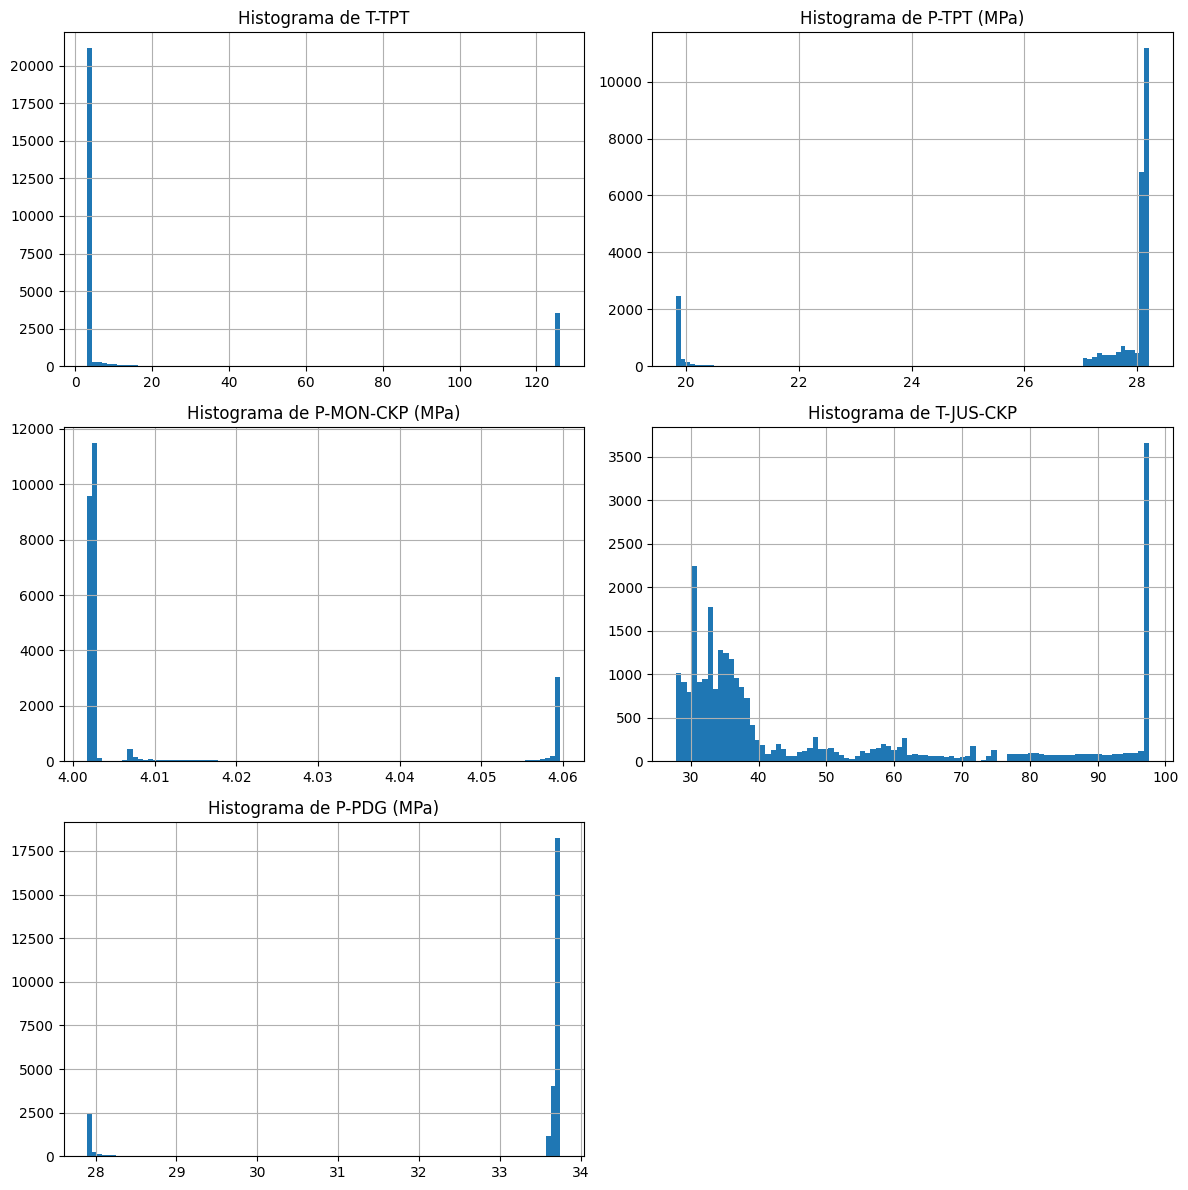

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

file_simulated_1='SIMULATED_00001.csv'
df_simulated_1=dfs[file_simulated_1]
n=12699

variables = ["T-TPT", "P-TPT (MPa)", "P-MON-CKP (MPa)", "T-JUS-CKP", "P-PDG (MPa)"]

intervalos_scott = {}

# Calcular el intervalo de Scott para cada variable
for var in variables:
    std = df_simulated_1[var].std()  # Desviación estándar de la variable
    intervalo_scott = (3.5 * std) / np.sqrt(n)
    intervalos_scott[var] = intervalo_scott

# Graficar los histogramas
plt.figure(figsize=(12, 12))

for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)  # Distribuir los gráficos en una cuadrícula 3x2
    intervalo_scott = intervalos_scott[var]  # Obtener el intervalo de Scott para la variable
    bins = int((df_simulated_1[var].max() - df_simulated_1[var].min()) / intervalo_scott)  # Calcular el número de bins
    df_simulated_1[var].hist(bins=bins)
    plt.title(f'Histograma de {var}')

plt.tight_layout()  # Ajustar automáticamente los espacios entre gráficos
plt.show()

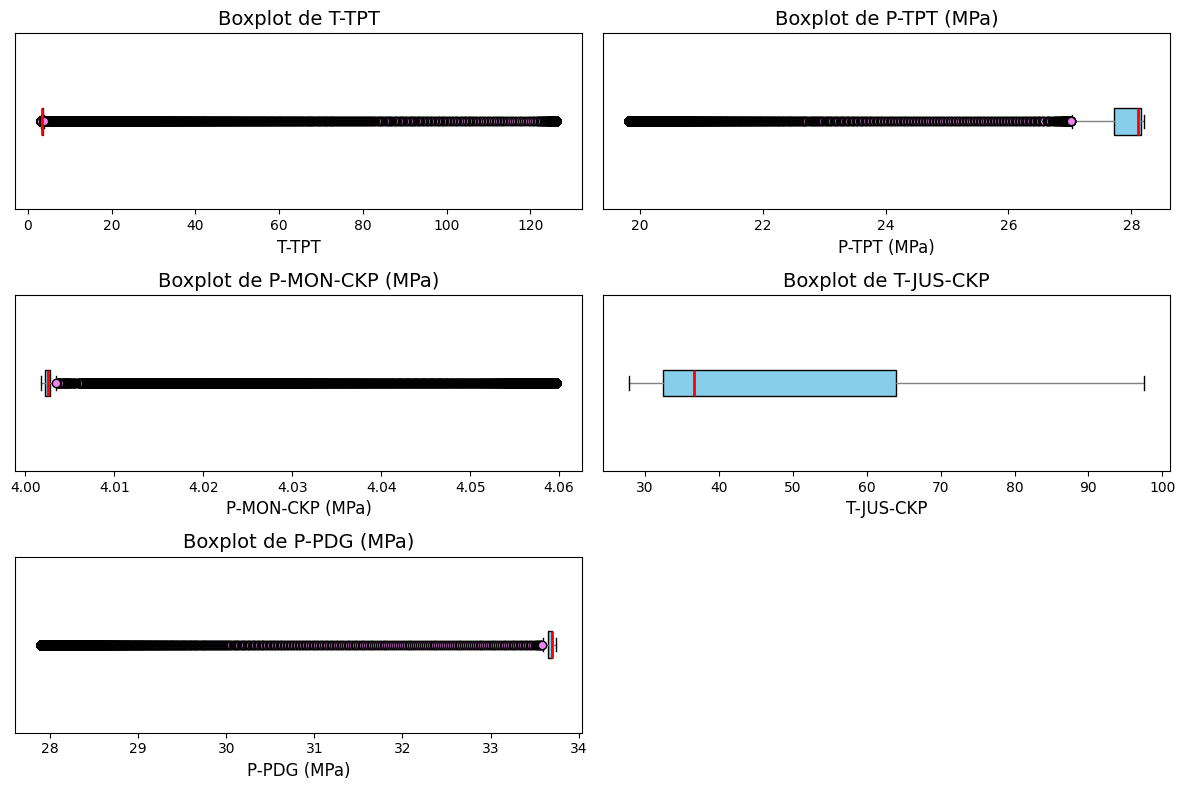

In [ ]:
# Graficar los boxplots
plt.figure(figsize=(12, 8))

# Definir propiedades para los outliers (más personalizable)
flierprops = dict(marker='o', markerfacecolor='violet', markersize=6, linestyle='none', markeredgecolor='black')
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    boxplot_parts = plt.boxplot(df_simulated_1[var], vert=False, flierprops=flierprops, patch_artist=True)

    # boxprops para el color de la caja
    boxplot_parts['boxes'][0].set(facecolor='skyblue', edgecolor='black')  # Color de la caja y borde

    # whiskerprops para el color de los "bigotes"
    for whisker in boxplot_parts['whiskers']:
        whisker.set(color='gray')

    # medianprops para el color y grosor de la mediana
    for median in boxplot_parts['medians']:
        median.set(color='red', linewidth=2)

    plt.title(f'Boxplot de {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.yticks([])

plt.tight_layout()
plt.show()

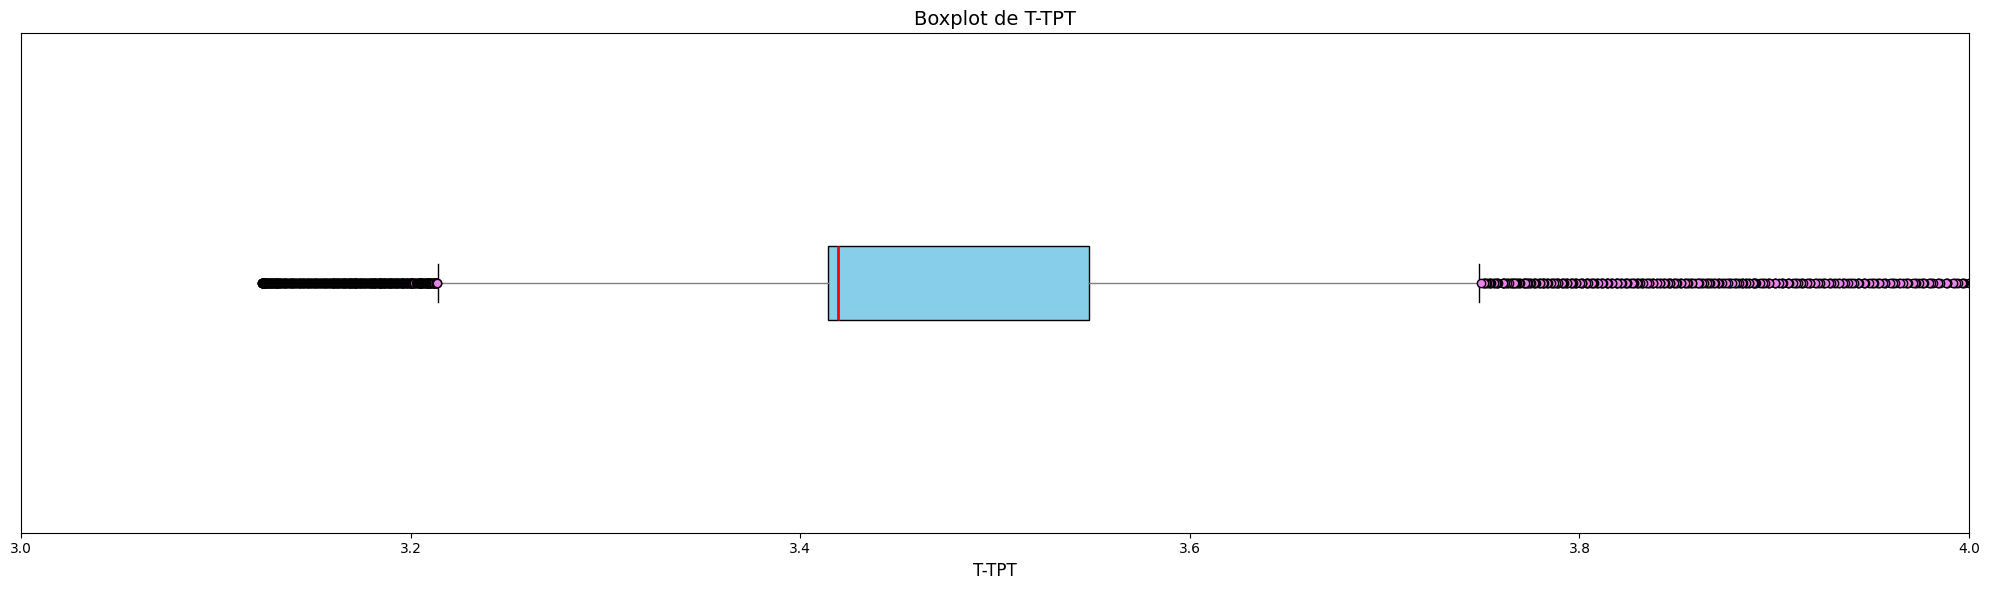

In [ ]:
# Grafico de nuevo el boxplot de T-TPT con otro tamaño y cortando los outliers porque debo visualizar la caja
plt.figure(figsize=(20, 6))  # Ajustar tamaño de la figura si es necesario

# Definir propiedades para los outliers
flierprops = dict(marker='o', markerfacecolor='violet', markersize=6, linestyle='none', markeredgecolor='black')

boxplot_parts = plt.boxplot(df_simulated_1['T-TPT'], vert=False, flierprops=flierprops, patch_artist=True)

# Estilos para la caja, bigotes y mediana (como antes)
boxplot_parts['boxes'][0].set(facecolor='skyblue', edgecolor='black')
for whisker in boxplot_parts['whiskers']:
    whisker.set(color='gray')
for median in boxplot_parts['medians']:
    median.set(color='red', linewidth=2)

plt.title('Boxplot de T-TPT', fontsize=14)
plt.xlabel('T-TPT', fontsize=12)
plt.yticks([])  # Ocultar ticks del eje Y

# Ajustar la escala horizontal (eje X)
plt.xlim(3, 4)  # Ajusta los límites según tus datos

plt.tight_layout()
plt.show()

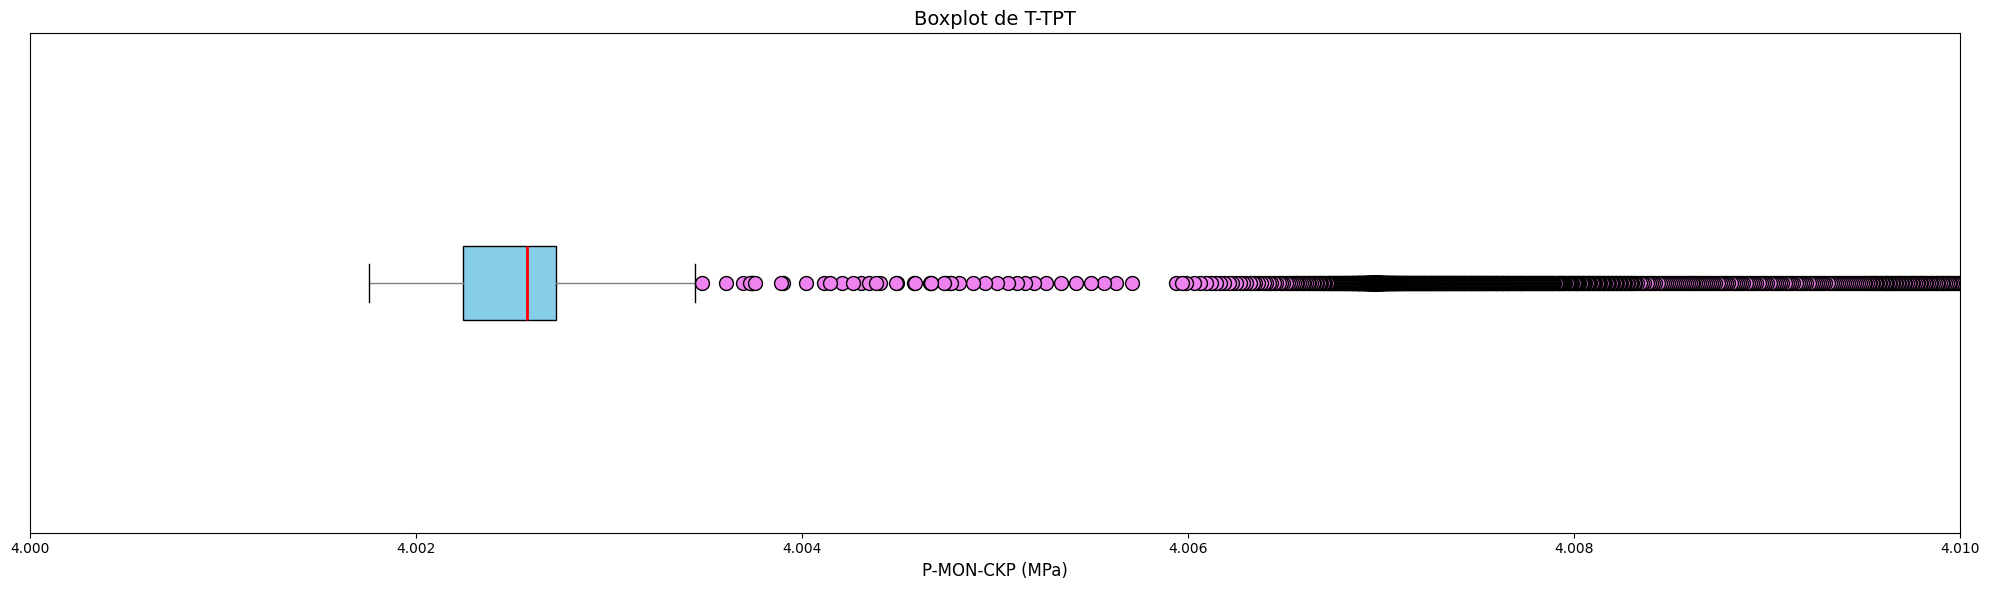

In [ ]:
# Grafico de nuevo el boxplot de P-MON-CKP con otro tamaño y cortando los outliers porque debo visualizar la caja
plt.figure(figsize=(20, 6))  # Ajustar tamaño de la figura si es necesario

# Definir propiedades para los outliers
flierprops = dict(marker='o', markerfacecolor='violet', markersize=10, linestyle='none', markeredgecolor='black')

boxplot_parts = plt.boxplot(df_simulated_1['P-MON-CKP (MPa)'], vert=False, flierprops=flierprops, patch_artist=True)

# Estilos para la caja, bigotes y mediana (como antes)
boxplot_parts['boxes'][0].set(facecolor='skyblue', edgecolor='black')
for whisker in boxplot_parts['whiskers']:
    whisker.set(color='gray')
for median in boxplot_parts['medians']:
    median.set(color='red', linewidth=2)

plt.title('Boxplot de T-TPT', fontsize=14)
plt.xlabel('P-MON-CKP (MPa)', fontsize=12)
plt.yticks([])  # Ocultar ticks del eje Y

# Ajustar la escala horizontal (eje X)
plt.xlim(4, 4.01)  # Ajusta los límites según tus datos

plt.tight_layout()
plt.show()

En cuanto a la variable **T-TPT**, el **histograma** sugiere que los valores se concentran más en los extremos que en el centro, con una mayor frecuencia de temperaturas bajas en comparación con las altas. Este patrón es consistente con la asimetría positiva previamente indicada por la media mayor a la mediana (cola larga a la derecha). Es decir, existen valores muy altos (outliers o valores atípicos) que están elevando la media. Aunque las temperaturas bajas son más frecuentes, los valores extremos elevados, aunque pocos, son lo suficientemente grandes como para desplazar la media hacia valores más altos, lo que refuerza la presencia de una asimetría positiva en la distribución.
Al observar el **boxplot**, se pueden ver varios outliers de temperaturas altas. La caja se extiende desde aproximadamente 3.4 hasta 3.55, lo que indica que el 50% central de los datos de T-TPT se encuentra en este rango. La línea de la mediana está ligeramente más cerca del borde inferior de la caja, lo que sugiere una asimetría hacia los valores más altos. Además, varios puntos atípicos se encuentran por encima del bigote superior, lo que confirma la presencia de valores inusualmente altos en los datos.

El análisis del **histograma de P-TPT** revela una distribución peculiar, con una concentración significativa de valores en los extremos. Se observan picos prominentes alrededor de 20 MPa y, especialmente, en 28 MPa.
El **boxplot** complementa esta visión mostrando una dispersión considerable de los datos, con una mediana ubicada cerca del tercer cuartil (Q3). La presencia de varios outliers por debajo del límite inferior sugiere la existencia de valores inusualmente bajos de P-TPT que podrían merecer una investigación más profunda. La ausencia de outliers por encima del límite superior indica que no hay valores extremadamente altos que se desvíen significativamente del resto de la distribución.

---

El **histograma de presion aguas arriba P-MON-PCK** revela una distribución con una alta frecuencia de valores centrados en 4 y 4.06 MPa. Esta concentración de valores sugiere una posible distribución simétrica, aunque con una ligera asimetría positiva (cola hacia la derecha).
El **boxplot** complementa esta información mostrando una dispersión considerable de los datos, con una mediana ligeramente desplazada hacia el tercer cuartil (Q3). La presencia de varios outliers por encima del límite superior indica la existencia de valores inusualmente altos de P-MON-PCK que se desvían significativamente del resto de la distribución. Estos outliers podrían brindar información relevante sobre el sistema en estudio por lo que no se van a descartar.


El **histograma de la temperatura aguas abajo (T-JUS-CKP)** revela una dispersión considerable de los datos. Si bien la media se sitúa en 50°C y la mediana en 36.63°C, esta diferencia sugiere una distribución asimétrica, con valores extremos que elevan la media. En efecto, se observan picos de temperatura significativamente altos, mientras que la mayoría de los datos se concentran en valores más bajos, entre 30 y 40°C.
El **boxplot** confirma esta asimetría y dispersión, mostrando una distribución donde no se identifican outliers. Esto implica que, si bien existen valores altos de temperatura, estos no se consideran atípicos según el criterio del boxplot.

---

Los **valores de presión en el manómetro (P-PDG)** se concentran frecuentemente entre 33 y 34 MPa, lo que sugiere un rango típico de operación del sistema. Sin embargo, se identifican algunos outliers en 28 MPa, lo que indica la presencia de eventos o condiciones inusuales que resultan en presiones más bajas. Estos outliers podrían indicar información relevante sobre el sistema en estudio.




### Análisis de los datos reales

En el archivo correspondiente al pozo WELL-00019, se observan las siguientes características:

T-JUS-CKP: En este caso, las medidas estadísticas son todas NaN. Al verificar contra el archivo CSV original, se confirma que esta columna no contiene ningún valor en dicho archivo.

Presiones: Para las demás variables de presión, los valores resultan ser 0, ya que todos los registros en este archivo contienen 0 en esas columnas.

P-MON-CKP: Esta variable presenta una media de 1.40 MPa y una mediana de 1.18 MPa, con un valor máximo de 3.15 MPa. Además, la desviación estándar es muy pequeña, lo que sugiere una distribución bastante estable. Este comportamiento se mantiene en los archivos de los otros dos pozos, WELL-00020 y WELL-00021, donde los datos de esta variable son consistentes y presentan medidas estadísticas similares.

Para el pozo WELL-00020:

T-TPT: La media es de 21°C, mientras que la mediana es de 14.97°C, con una desviación estándar de 14°C. Esto indica que podría tratarse de una distribución asimétrica.

P-TPT: La media es de 1378.7 MPa y la mediana de 1405.1 MPa. Dado que la media y la mediana son bastante similares, no parece haber una desviación asimétrica significativa en esta variable.

P-MON-CKP: La media es de 2.97 MPa y la mediana de 3.15 MPa, lo que indica una distribución simétrica.

T-JUS-CKP: No se encuentran valores en este pozo.

P-PDG (presión en el manómetro): La media es de 2254 MPa y la mediana de 2262 MPa, con valores bastante cercanos, lo que sugiere una distribución simétrica.

Una observación importante es la diferencia entre las presiones reales y las de los datos simulados. Esto podría deberse a la naturaleza de los modelos de simulación, que no siempre replican con precisión las condiciones reales del pozo. Es recomendable investigar este aspecto para comprender mejor las discrepancias.

Para el pozo WELL-00021:

T-TPT: La media es de 13°C y la mediana de 16°C, con una desviación estándar de 5.47°C. Esto indica una distribución con ligera asimetría, pero los valores no parecen estar excesivamente dispersos.

P-TPT: La media es de 1448 MPa y la mediana de 1648 MPa, lo que sugiere que podrían existir outliers (valores extremos), ya que la diferencia entre la media y la mediana es considerable. El valor máximo observado en esta columna es de 1979 MPa, lo que refuerza la hipótesis de la presencia de valores atípicos.

P-MON-CKP: La media es de 1.42 MPa y la mediana de 1.33 MPa, lo que indica que los valores se mantienen cercanos, sugiriendo una distribución simétrica.

T-JUS-CKP: No contiene valores en este pozo.

P-PDG: La media es de 3085 MPa y la mediana de 3084 MPa, lo que indica que esta variable no presenta fluctuaciones importantes en este pozo.

Conclusiones finales:

En los datos de los pozos WELL-00019 y WELL-00020, los valores de temperatura y presión parecen seguir patrones consistentes, aunque se observan algunas columnas con valores faltantes, como es el caso de T-JUS-CKP. Por otro lado, las presiones de los pozos reales, en particular P-TPT y P-MON-CKP, muestran una estabilidad que podría sugerir una distribución simétrica en su mayoría. Sin embargo, en el pozo WELL-00021, la presencia de outliers en P-TPT requiere una atención especial, ya que estos valores atípicos podrían influir en la interpretación del comportamiento de las presiones.


---

Haremos uso de los histogramas para vsualizar la informacion real de los pozos WELL-00020 y WEL-00021 y en este caso se analizaran de forma mas resumida los datos. Luego se procederá con la evaluación mediante boxplots para identificar los outliers. Este análisis no tiene como objetivo eliminar ni descartar los datos, sino identificar los timestamps correspondientes a los valores atípicos y analizar su posible relación con la formación de hidratos. Este enfoque permitirá evaluar si existe un patrón entre la presencia de valores atípicos y las condiciones que favorecen la formación de hidratos.

